# Binary Human-Written vs Machine-Generated Text Classification

### Imports

In [ ]:
# Run this cell to install the required packages

#TODO: add all packages that need to be installed in colab
# !pip install ipywidgets   #TODO: test if ipywidgets works also in colab or if must use @param etc.

In [4]:
import json
import random
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from ipywidgets import interact

## Data Loading

In [2]:
train_data = []
with open('./data/subtaskA_train_monolingual.jsonl') as f:
    for line in f:
        train_data.append(json.loads(line))
    
test_data = []
with open('./data/subtaskA_dev_monolingual.jsonl') as f:
    for line in f:
        test_data.append(json.loads(line))

## Data exploration

In [3]:
@interact(i=(0, len(train_data)-1, 1))
def print_datapoint(i):
    return train_data[i]

interactive(children=(IntSlider(value=59878, description='i', max=119756), Output()), _dom_classes=('widget-in…

In [40]:
print(f"Size of training data: {len(train_data)}")
print(f"Size of test data: {len(test_data)}")

Size of training data: 119757
Size of test data: 5000


### Plots

In [77]:
# Convert the data (except for the text part) to a pandas dataframe in order to plot more easiliy
train_df_stats = pd.DataFrame(columns=['label', 'model', 'source', 'word_count'], index=[i for i in range(len(train_data))])

for i, d in enumerate(train_data):
    train_df_stats.loc[d['id']] = pd.Series({'label': d['label'], 'model': d['model'], 'source': d['source'], 'word_count': len(d['text'].split())})

In [78]:
train_df_stats.head()

,label,model,source,word_count
0,1,chatGPT,wikihow,407
1,1,chatGPT,wikihow,681
2,1,chatGPT,wikihow,913
3,1,chatGPT,wikihow,808
4,1,chatGPT,wikihow,569


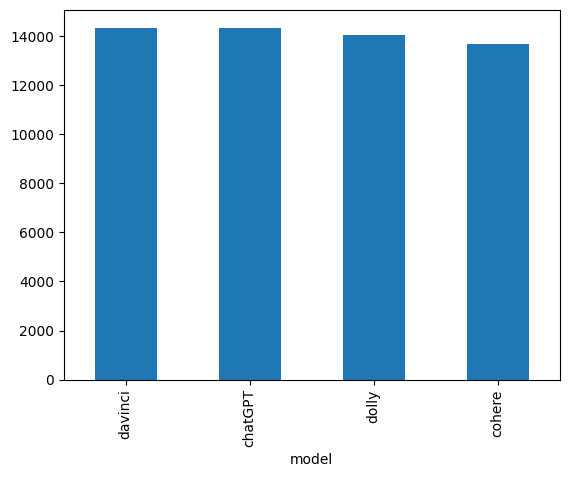

In [85]:
train_df_stats[train_df_stats['label'] == 1]['model'].value_counts().plot(kind='bar');

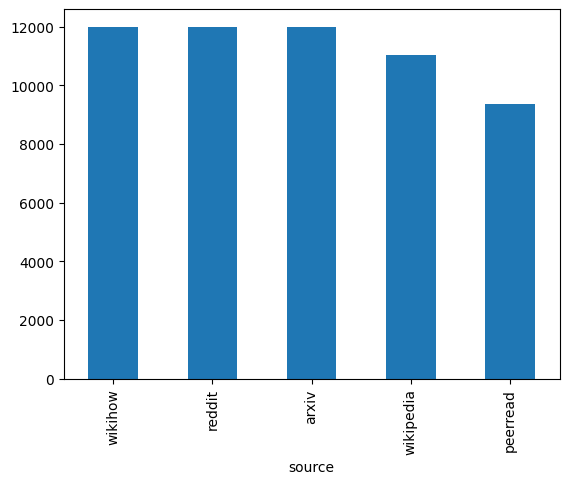

In [86]:
train_df_stats[train_df_stats['label'] == 1]['source'].value_counts().plot(kind='bar');

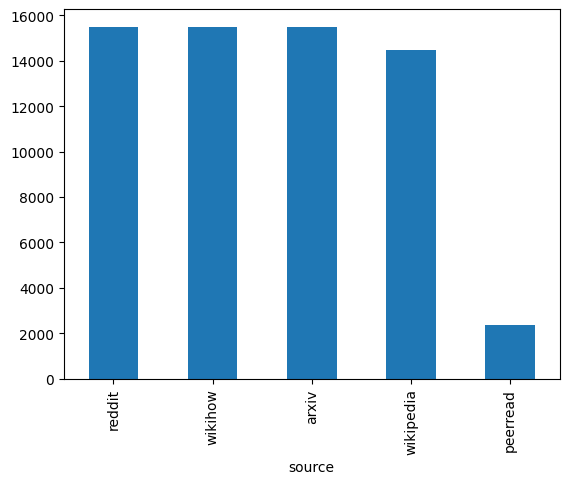

In [87]:
train_df_stats[train_df_stats['label'] == 0]['source'].value_counts().plot(kind='bar');

In [88]:
# TODO: what to do with the fact that we have much less peerread in the human written data???

The data is pretty balanced with respect to the fields "model" and "source".

We ignore these two in the following steps (as model would be only useful for a harder multiclass classification, source could be optionally passed to the model [TODO: try] to give more context) but keep them in the data to look for insights in the error analysis phase.

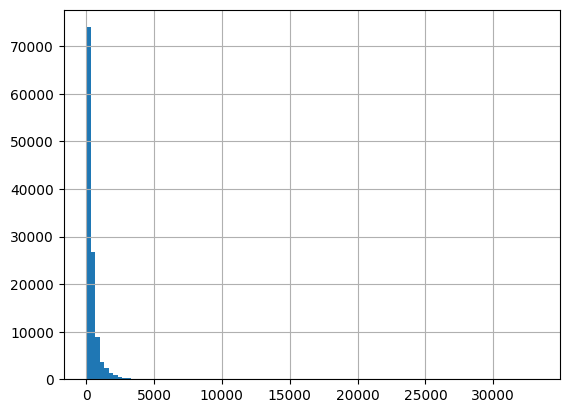

In [89]:
train_df_stats['word_count'].hist(bins=100);

Plot considering 99.69% of the data


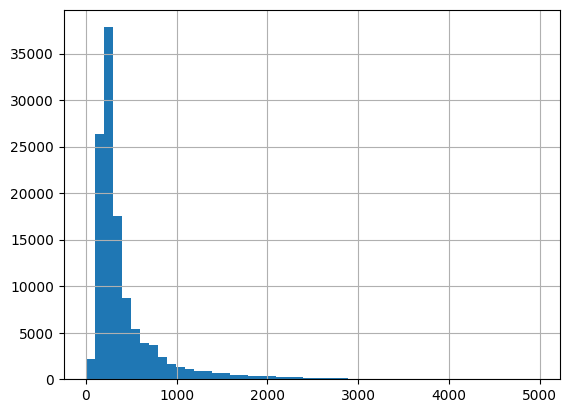

In [91]:
# Let's consider for a moment only the data below a certain threshold length (5000) for a more informative plot
print(f"Plot considering {len(train_df_stats[train_df_stats['word_count'] < 5000]) / len(train_df_stats) * 100 :.2f}% of the data")
train_df_stats[train_df_stats['word_count'] < 5000]['word_count'].hist(bins=50);

## Data preparation

In the lack of a complete train/val/test split, we considered the dataset provided as "development" (dev), i.e. validation set, as the test set and split the "train" dataset file using an **90/10 train/val split**.

We did so while maintaining class proportions invariate.

In [37]:
positive_data = [d for d in train_data if d['label'] == 1]
negative_data = [d for d in train_data if d['label'] == 0]

test_split = 0.1
positive_train_data, positive_val_data = train_test_split(positive_data, test_size=test_split, random_state=42)
negative_train_data, negative_val_data = train_test_split(negative_data, test_size=test_split, random_state=42)

train_data = positive_train_data + negative_train_data
val_data = positive_val_data + negative_val_data

# Shuffle the data
random.seed(42)
random.shuffle(train_data)

In [38]:
def print_stats(data, name):
    avg_text_len = 0
    positives = 0

    for d in data:
        assert d['label'] in [0, 1]

        positives += int(d['label'])
        avg_text_len += len(d['text'].split(' '))

    print(f"Stats for {name} data:")
    print(f"Number of texts: {len(data)}")
    print(f"Average number of words in text field: {avg_text_len/len(data):.2f}")
    print(f"Percentage of texts labeled as 1s (machine generated): {positives/len(data)*100:.2f}% \n")

In [39]:
print_stats(train_data, "training")
print_stats(val_data, "validation")
print_stats(test_data, "test")

Stats for training data:
Number of texts: 107780
Average number of words in text field: 450.67
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for validation data:
Number of texts: 11977
Average number of words in text field: 460.13
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for test data:
Number of texts: 5000
Average number of words in text field: 338.02
Percentage of texts labeled as 1s (machine generated): 50.00% 



In [ ]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## Metrics

## Models

### Baseline

## Training

## Evaluation

## Error analysis